<a href="https://colab.research.google.com/github/sokrypton/7.571/blob/main/L2/phylogeny_bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bootstrap in Phylogenetics

**Connection to CLT/Bootstrap lecture:**

| Statistical Problem | Phylogenetics Problem |
|---------------------|----------------------|
| One sample → estimate mean | One alignment → estimate tree |
| How confident is our mean? | How confident is each branch? |
| Bootstrap: resample data points | Bootstrap: resample columns |
| SE = std of bootstrap means | Support = % trees with that branch |

In [1]:
# Install biopython
!pip -q install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 20.5 MB/s eta 0:00:00


In [2]:
# Download example alignment
!wget -qnc https://raw.githubusercontent.com/sokrypton/ws2023/main/day1/phy_msa_ext.fasta

In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from Bio import Phylo
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceCalculator
from Bio.Phylo.Consensus import bootstrap, bootstrap_trees, get_support

def rm_inner(tree):
    """Remove labels from inner nodes (cleaner visualization)"""
    for node in tree.get_nonterminals():
        node.name = None

## Step 1: Load the alignment

A multiple sequence alignment (MSA) has:
- Rows = species/sequences
- Columns = positions (characters)

In [4]:
# Load alignment
aln = AlignIO.read('phy_msa_ext.fasta', 'fasta')
print(aln)

Alignment with 5 rows and 13 columns
AACGTGGCCACAT Alpha
AAGGTCGCCACAC Beta
CAGTTCGCCACAA Gamma
GAGATTTCCGCCT Delta
GAGATCTCCGCCC Epsilon


## Step 2: Build a tree (Distance Method)

1. Compute pairwise distances between sequences
2. Use UPGMA algorithm to build tree

In [5]:
# Compute distance matrix
dist_mtx = DistanceCalculator('identity').get_distance(aln)
print(dist_mtx)

Alpha   0.000000
Beta    0.230769    0.000000
Gamma   0.384615    0.230769    0.000000
Delta   0.538462    0.538462    0.538462    0.000000
Epsilon 0.615385    0.384615    0.461538    0.153846    0.000000
    Alpha   Beta    Gamma   Delta   Epsilon


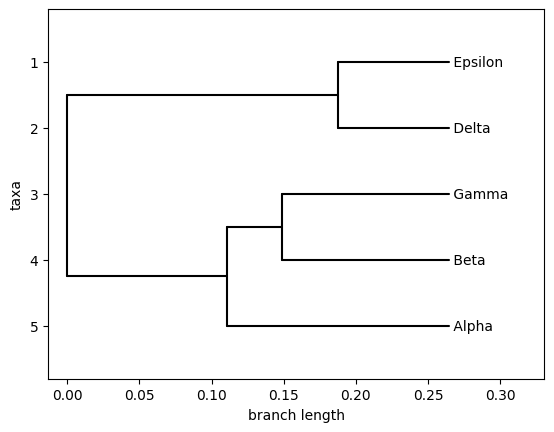

In [6]:
# Build tree using UPGMA
upgma_tree = DistanceTreeConstructor().upgma(dist_mtx)
rm_inner(upgma_tree)
Phylo.draw(upgma_tree)

## Step 3: The Problem

We have **ONE alignment** → **ONE tree**

But how confident are we in each branch?

**Sound familiar?** Same problem as estimating SE from one sample!

## Step 4: Bootstrap — Resample COLUMNS

Key insight: Each column is like one data point.

Bootstrap = resample columns **with replacement**
- Some columns appear multiple times
- Some columns don't appear at all

In [7]:
# Generate 100 bootstrap alignments
bootstrap_alns = list(bootstrap(aln, 100))

print("Original alignment:")
print(aln)
print("\n" + "="*50)
print("One bootstrap resample:")
print("(Notice: some columns repeat, some are missing!)")
print("="*50 + "\n")
print(bootstrap_alns[0])

Original alignment:
Alignment with 5 rows and 13 columns
AACGTGGCCACAT Alpha
AAGGTCGCCACAC Beta
CAGTTCGCCACAA Gamma
GAGATTTCCGCCT Delta
GAGATCTCCGCCC Epsilon

One bootstrap resample:
(Notice: some columns repeat, some are missing!)

Alignment with 5 rows and 13 columns
ACAAGACGCCACC Alpha
ACAACACCCCACC Beta
ACACCCCCCCACC Gamma
ACAGTGCTCCCCC Delta
ACAGCGCCCCCCC Epsilon


## Step 5: Build a tree from EACH bootstrap alignment

In [8]:
# Build 100 trees from 100 bootstrap alignments
upgma_trees = list(bootstrap_trees(aln, 100,
    DistanceTreeConstructor(DistanceCalculator('identity'), 'upgma')))

print(f"We now have {len(upgma_trees)} trees!")

We now have 100 trees!


Bootstrap tree 1


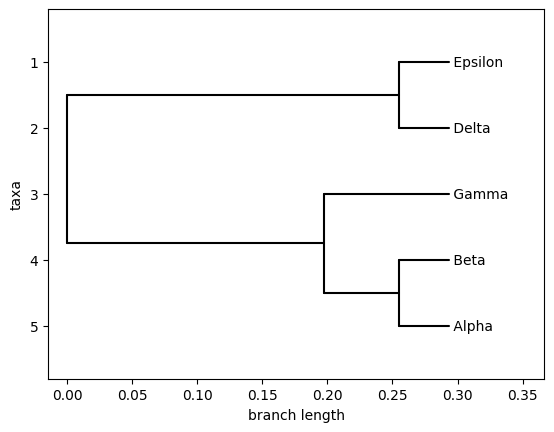

Bootstrap tree 2


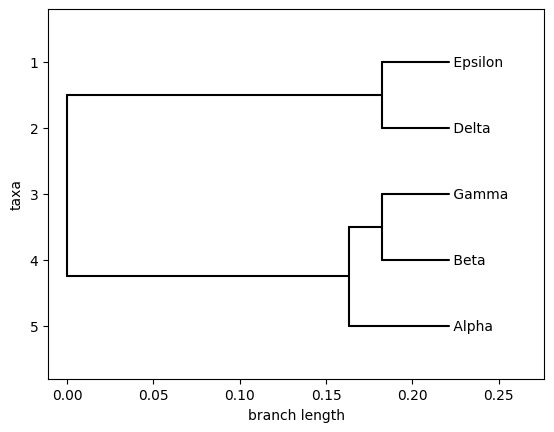

Bootstrap tree 3


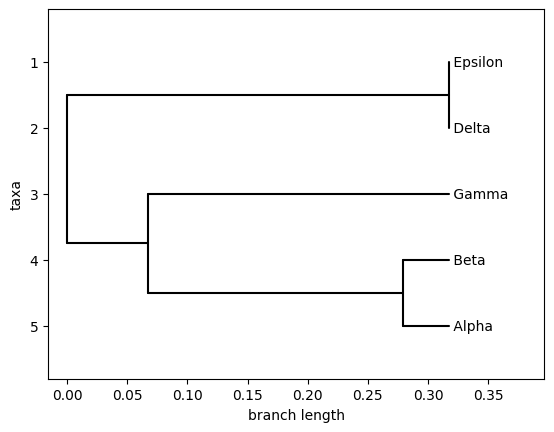

In [9]:
# Look at first 3 trees — they're slightly different!
for i in range(3):
    print("="*50)
    print(f"Bootstrap tree {i+1}")
    print("="*50)
    rm_inner(upgma_trees[i])
    Phylo.draw(upgma_trees[i])

## Step 6: Calculate Bootstrap Support

For each branch in our original tree:
- Count how many bootstrap trees have that same branch
- Express as percentage (0-100)

This is like calculating the "distribution" of our tree estimate!

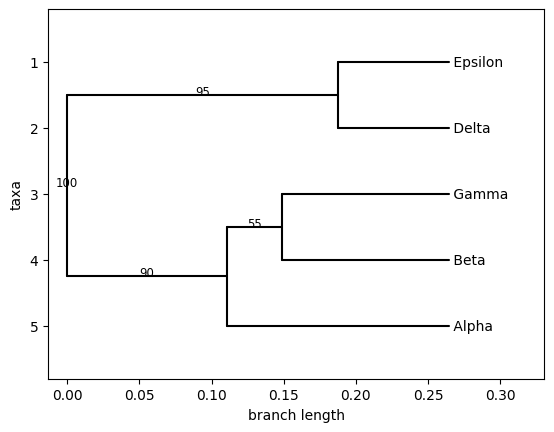

In [10]:
# Add bootstrap support values to our tree
upgma_tree_with_support = get_support(upgma_tree, upgma_trees)
Phylo.draw(upgma_tree_with_support)

In [11]:
print("Interpreting Bootstrap Support Values")
print("=" * 50)
print("Number on branch = % of bootstrap trees with that branch")
print("")
print("  > 90%  : Strong support (confident!)")
print("  70-90% : Moderate support")
print("  < 70%  : Weak support (uncertain)")

Interpreting Bootstrap Support Values
Number on branch = % of bootstrap trees with that branch

  > 90%  : Strong support (confident!)
  70-90% : Moderate support
  < 70%  : Weak support (uncertain)


## Summary: Bootstrap for Phylogenetics

| Step | What we do |
|------|------------|
| 1 | Start with ONE alignment |
| 2 | Resample COLUMNS with replacement → many alignments |
| 3 | Build tree from each → many trees |
| 4 | Count how often each branch appears → **confidence!** |

**Same logic as bootstrap for SE:**
- Instead of mean → we compute tree topology
- Instead of SE → we get support values

**The statistic can be ANYTHING — even a tree!**